In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("./income.csv")

In [4]:
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [5]:
df['label'].value_counts()

label
0    21700
1     8300
Name: count, dtype: int64

In [6]:
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

In [7]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [8]:
df = shuffle(df, random_state=101)
df.reset_index(drop=True, inplace=True)
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,23,Female,HS-grad,9,Never-married,Private,Other-service,50,<=50K,0
1,37,Female,Prof-school,15,Married,State-gov,Prof-specialty,39,>50K,1
2,34,Male,Some-college,10,Divorced,Private,Adm-clerical,40,<=50K,0
3,31,Male,HS-grad,9,Married,Private,Craft-repair,40,>50K,1
4,20,Female,Some-college,10,Never-married,Private,Sales,25,<=50K,0


In [9]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

In [10]:

sx = df['sex'].cat.codes.values
ed = df['education'].cat.codes.values
ms = df['marital-status'].cat.codes.values
wc = df['workclass'].cat.codes.values
oc = df['occupation'].cat.codes.values

cats = np.stack([sx,ed,ms,wc,oc], 1)

cats[:5]

array([[ 0, 10,  3,  2,  6],
       [ 0, 12,  1,  4,  7],
       [ 1, 13,  0,  2,  0],
       [ 1, 10,  1,  2,  1],
       [ 0, 13,  3,  2,  9]], dtype=int8)

In [11]:
cats = torch.tensor(cats, dtype=torch.int64)

In [12]:
conts = np.stack([df[col].values for col in cont_cols], 1)
conts[:5]

array([[23, 50],
       [37, 39],
       [34, 40],
       [31, 40],
       [20, 25]])

In [13]:
conts = torch.tensor(conts, dtype=torch.float)
conts.dtype

torch.float32

In [14]:
y = torch.tensor(df[y_col].values).flatten()

In [15]:
y

tensor([0, 1, 0,  ..., 1, 0, 1])

In [16]:
b = 30000 # suggested batch size
t = 5000  # suggested test size

cat_train = cats[:b-t]
cat_test  = cats[b-t:b]
con_train = conts[:b-t]
con_test  = conts[b-t:b]
y_train   = y[:b-t]
y_test    = y[b-t:b]

In [17]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

In [18]:
torch.manual_seed(33)

In [20]:
model = TabularModel(emb_szs, conts.shape[1], 2, [50], p=0.4)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

epoch:   1  loss: 0.31324983
epoch:  26  loss: 0.31053504
epoch:  51  loss: 0.30555499
epoch:  76  loss: 0.30273521
epoch: 101  loss: 0.30086908
epoch: 126  loss: 0.29858872
epoch: 151  loss: 0.29439232
epoch: 176  loss: 0.29116037
epoch: 201  loss: 0.28944671
epoch: 226  loss: 0.28769010
epoch: 251  loss: 0.28790537
epoch: 276  loss: 0.28995341
epoch: 300  loss: 0.29113221

Duration: 28 seconds


Text(0.5, 0, 'epoch')

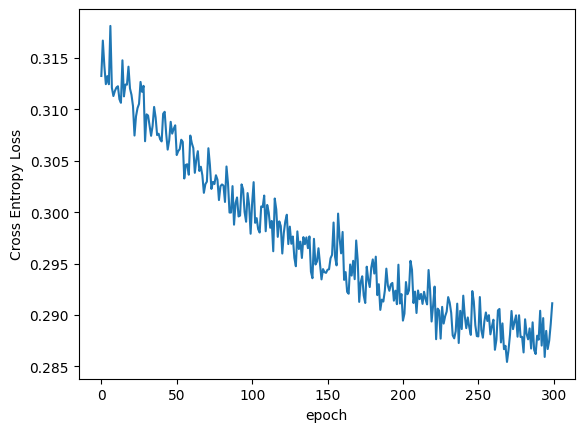

In [26]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch')

In [27]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.31019413


In [28]:
rows = len(y_test)
correct = 0

# print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')

for i in range(rows):
    # print(f'{str(y_val[i]):26} {y_val[i].argmax().item():^7}{y_test[i]:^7}')

    if y_val[i].argmax().item() == y_test[i]:
        correct += 1

print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')


4272 out of 5000 = 85.44% correct


In [29]:
rows = len(y_test)
correct = 0

# print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')

for i in range(rows):
    # print(f'{str(y_val[i]):26} {y_val[i].argmax().item():^7}{y_test[i]:^7}')

    if y_val[i].argmax().item() == y_test[i]:
        correct += 1

print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')


4272 out of 5000 = 85.44% correct


In [30]:
def test_data(mdl): # pass in the name of the model
    # INPUT NEW DATA
    age = float(input("What is the person's age? (18-90)  "))
    sex = input("What is the person's sex? (Male/Female) ").capitalize()
    edn = int(input("What is the person's education level? (3-16) "))
    mar = input("What is the person's marital status? ").capitalize()
    wrk = input("What is the person's workclass? ").capitalize()
    occ = input("What is the person's occupation? ").capitalize()
    hrs = float(input("How many hours/week are worked? (20-90)  "))

    # PREPROCESS THE DATA
    sex_d = {'Female':0, 'Male':1}
    mar_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
    wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
    occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
            'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9, 
            'Tech-support':10, 'Transport-moving':11}

    sex = sex_d[sex]
    mar = mar_d[mar]
    wrk = wrk_d[wrk]
    occ = occ_d[occ]

    # CREATE CAT AND CONT TENSORS
    cats = torch.tensor([sex,edn,mar,wrk,occ], dtype=torch.int64).reshape(1,-1)
    conts = torch.tensor([age,hrs], dtype=torch.float).reshape(1,-1)
    
    # SET MODEL TO EVAL (in case this hasn't been done)
    mdl.eval()

    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(cats, conts).argmax().item()

    print(f'\nThe predicted label is {z}')
    
test_data(model)

What is the person's age? (18-90)  22
What is the person's sex? (Male/Female) Male
What is the person's education level? (3-16) 4
What is the person's marital status? Married
What is the person's workclass? Federal-gov
What is the person's occupation? Adm-clerical
How many hours/week are worked? (20-90)  49

The predicted label is 0
